# Customer Churn Prediction

Customer attrition, also known as customer churn, customer turnover, or customer defection, is the loss of clients or customers.

Telephone service companies, Internet service providers, pay TV companies, insurance firms, and alarm monitoring services, often use customer attrition analysis and customer attrition rates as one of their key business metrics because the cost of retaining an existing customer is far less than acquiring a new one. Companies from these sectors often have customer service branches which attempt to win back defecting clients, because recovered long-term customers can be worth much more to a company than newly recruited clients.

Companies usually make a distinction between voluntary churn and involuntary churn. Voluntary churn occurs due to a decision by the customer to switch to another company or service provider, involuntary churn occurs due to circumstances such as a customer's relocation to a long-term care facility, death, or the relocation to a distant location. In most applications, involuntary reasons for churn are excluded from the analytical models. Analysts tend to concentrate on voluntary churn, because it typically occurs due to factors of the company-customer relationship which companies control, such as how billing interactions are handled or how after-sales help is provided.

predictive analytics use churn prediction models that predict customer churn by assessing their propensity of risk to churn. Since these models generate a small prioritized list of potential defectors, they are effective at focusing customer retention marketing programs on the subset of the customer base who are most vulnerable to churn.

Data Set Downloaded from Kaggle: https://www.kaggle.com/blastchar/telco-customer-churn

In [138]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
#standard imports
import os
import sys
import pickle
from collections import Counter
sys.path.append('..')

#Third-party library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import roc_curve, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Local imports
from src.localpaths import *
from src.data.make_dataset import load_training_data, load_test_data
from src.models.train_model import store_model_and_results, print_model_results, load_model_results, load_pickled_model
from src.visualization.visualize import plot_learning_curve
from src.models.predict_model import predict

In [140]:
#pd.options.display.max_columns=100
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

## 01. Load Data

In [141]:
df = pd.read_csv(RAW_DATA_PATH)

In [142]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Descriptive Statistics

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**TotalCharges needs more research:** it looks like TotalCharges is an `object` data type even though it should be `float` 

In [144]:
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [145]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [146]:
df.corr()

,SeniorCitizen,tenure,MonthlyCharges
SeniorCitizen,1.000000,0.016567,0.220173
tenure,0.016567,1.000000,0.247900
MonthlyCharges,0.220173,0.247900,1.000000


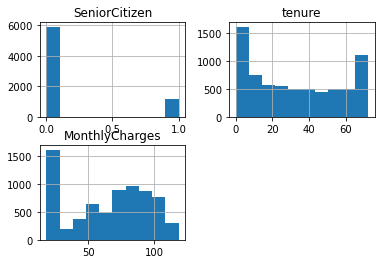

In [147]:
df.hist()
plt.show()

## Target Balance

In [148]:
(df['Churn'].value_counts() / df.shape[0]).round(2)

No     0.73
Yes    0.27
Name: Churn, dtype: float64

## Load training data

In [149]:
X_train, y_train = load_training_data(clean=True)

## Basic EDA - distribution of features

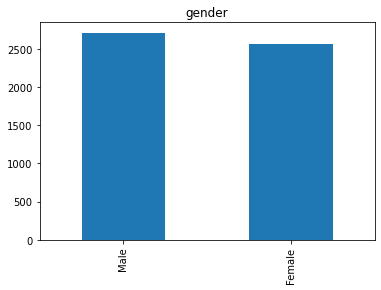

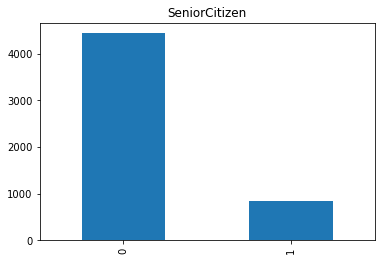

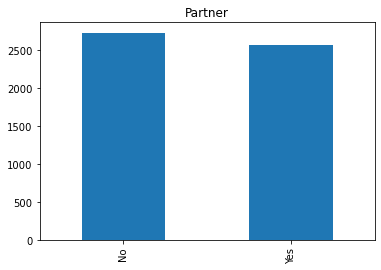

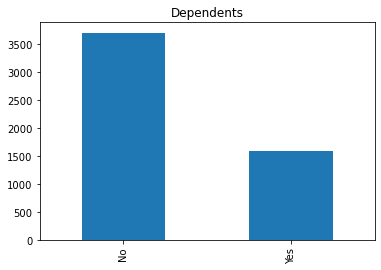

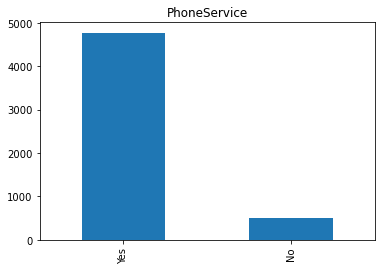

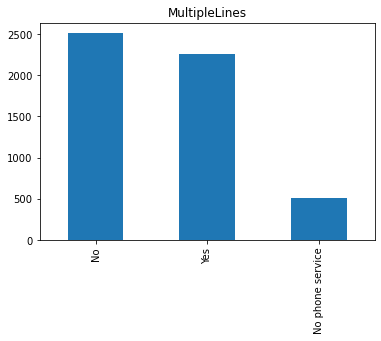

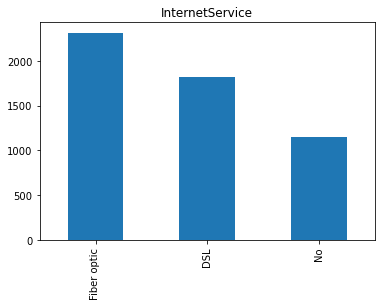

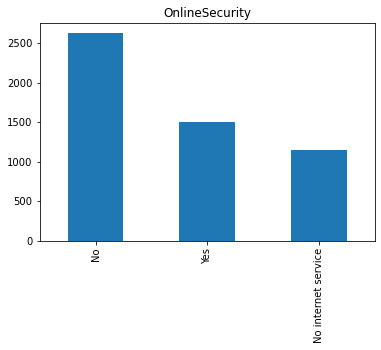

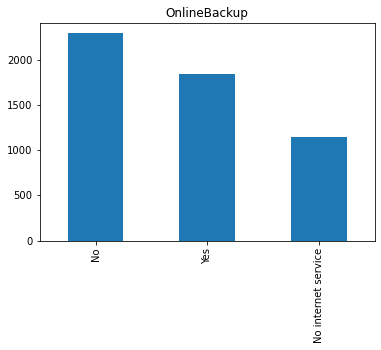

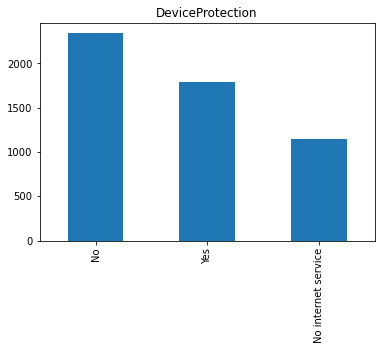

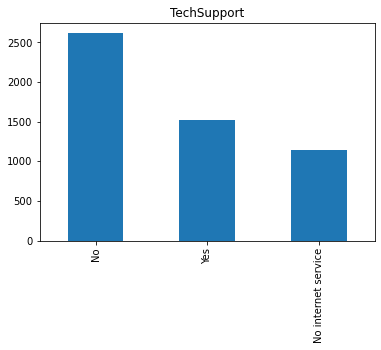

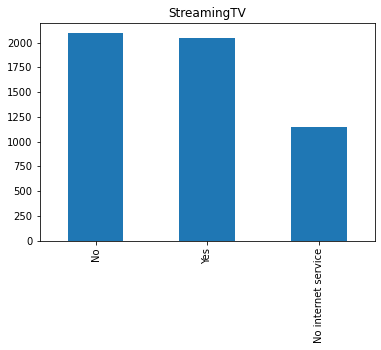

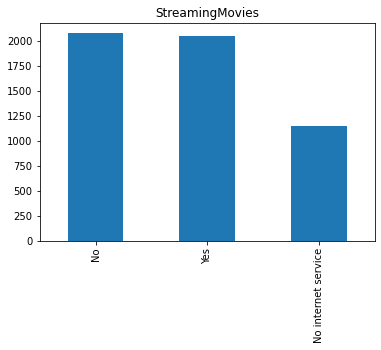

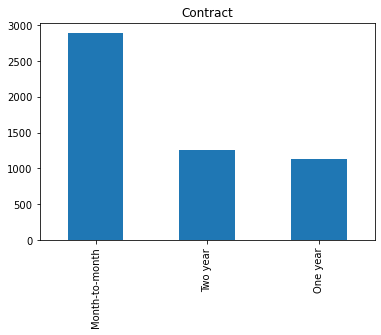

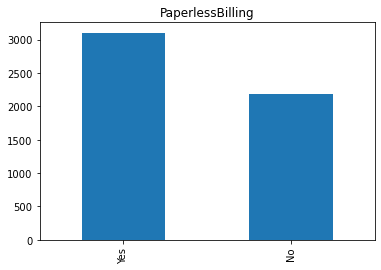

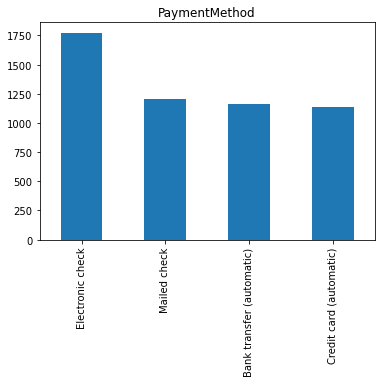

In [150]:
for col in X_train.columns:
    if len(X_train[col].unique()) <= 4:
        X_train[col].value_counts().plot(kind='bar')
        plt.title(col)
        plt.show()

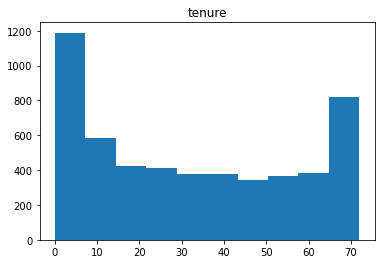

In [151]:
X_train['tenure'].hist(grid=False)
plt.title('tenure')
plt.show()

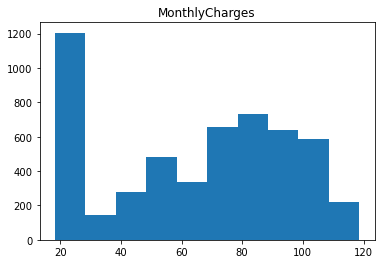

In [152]:
X_train['MonthlyCharges'].hist(grid=False)
plt.title('MonthlyCharges')
plt.show()

## Inspect TotalCharges

In [153]:
# bad_values = set()
# for val in X_train['TotalCharges'].unique():
#     try:
#         float(val)
#     except:
#         bad_values.add(val)

# (X_train['TotalCharges'] == ' ').sum()

# total_charges = X_train[ X_train['TotalCharges']!=' ' ]['TotalCharges'].map(float)

# total_charges.describe()

# # since the distribution is skewed, i choose 20 be a good value to impute TotalCharges missing value
# bad_values_idxs = X_train[ X_train['TotalCharges'] == ' '].index
# X_train.loc[ bad_values_idxs, 'TotalCharges'] = 20
# X_train['TotalCharges'] = X_train['TotalCharges'].astype(float)

# X_train['TotalCharges'].describe()

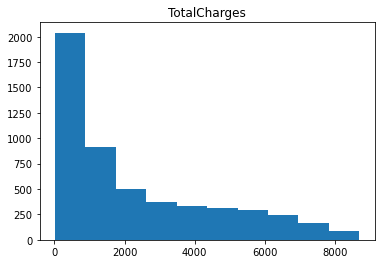

In [154]:
X_train['TotalCharges'].hist(grid=False)
plt.title('TotalCharges')
plt.show()

In [155]:
#X_train.select_dtypes(exclude=['object'])
#X_train.select_dtypes(include=['object'])

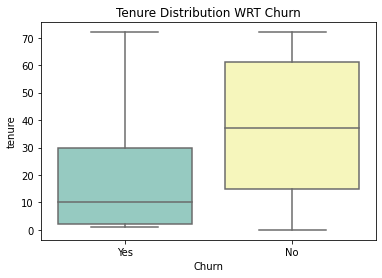

In [156]:
sns.boxplot(x = "Churn", y = "tenure", 
            data = X_train.select_dtypes(exclude=['object']).assign(**y_train), palette="Set3")
plt.title('Tenure Distribution WRT Churn')
plt.show()

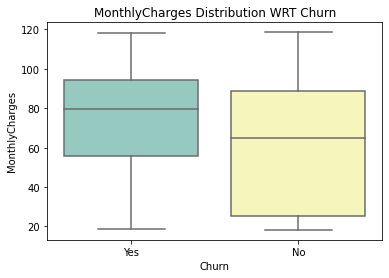

In [157]:
sns.boxplot(x = "Churn", y = "MonthlyCharges", 
            data = X_train.select_dtypes(exclude=['object']).assign(**y_train), palette="Set3")
plt.title('MonthlyCharges Distribution WRT Churn')
plt.show()

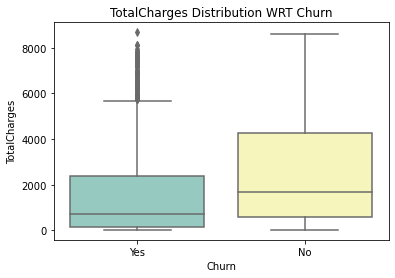

In [158]:
sns.boxplot(x = "Churn", y = "TotalCharges", 
            data = X_train.select_dtypes(exclude=['object']).assign(**y_train), palette="Set3")
plt.title('TotalCharges Distribution WRT Churn')
plt.show()

## 02. Load Featurized Data 

In [159]:
# This step loads clean, binary encoded, one-hot encoded, droped high VIF features
X_train, y_train = load_training_data(final=True)

In [160]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,0,7,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,0,0,1,4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,0,0,29,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,0,0,0,3,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [161]:
X_train.shape

(5282, 21)

In [162]:
X_train.corr()

,gender,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
gender,1.000000,0.005691,0.010143,-0.011058,-0.001318,0.014090,-0.009706,0.003307,0.014528,0.021021,0.025536,0.010371,0.011906,0.013873,-0.003996,0.012052,-0.008001,0.003300,0.000447,-0.006270,-0.004089
SeniorCitizen,0.005691,1.000000,0.016648,-0.211271,0.006169,0.156417,-0.000581,0.123974,0.255584,-0.036739,0.070836,0.067831,-0.057097,0.102617,-0.189718,0.119373,-0.046580,-0.125754,-0.024547,0.167972,-0.147658
Partner,0.010143,0.016648,1.000000,0.447629,0.382443,-0.020634,-0.031578,0.154350,0.009474,0.151724,0.153876,0.156254,0.125586,0.124236,0.000755,0.110650,0.086468,0.254102,0.105695,-0.082986,-0.108460
Dependents,-0.011058,-0.211271,0.447629,1.000000,0.162921,-0.109935,0.005830,-0.021619,-0.169426,0.085854,0.027996,0.010485,0.066857,-0.017083,0.139496,-0.037314,0.062427,0.206994,0.082329,-0.152754,0.053380
tenure,-0.001318,0.006169,0.382443,0.162921,1.000000,0.004055,-0.005917,0.342159,0.025088,0.329459,0.361964,0.361612,0.330507,0.280702,-0.043782,0.292136,0.203930,0.556371,0.238479,-0.200369,-0.233260
PaperlessBilling,0.014090,0.156417,-0.020634,-0.109935,0.004055,1.000000,-0.014489,0.169690,0.333920,0.010410,0.123735,0.112994,0.041767,0.230622,-0.327897,0.206972,-0.051368,-0.156178,-0.021134,0.214575,-0.207767
MultipleLines_No phone service,-0.009706,-0.000581,-0.031578,0.005830,-0.005917,-0.014489,1.000000,-0.282513,-0.288234,0.086044,0.058281,0.074532,0.084202,0.022690,-0.172087,0.028911,0.010171,-0.010091,0.022687,-0.008085,-0.006735
MultipleLines_Yes,0.003307,0.123974,0.154350,-0.021619,0.342159,0.169690,-0.282513,1.000000,0.366256,0.098304,0.214043,0.208932,0.110631,0.253717,-0.208190,0.265536,-0.008402,0.117838,0.059346,0.081522,-0.222375
InternetService_Fiber optic,0.014528,0.255584,0.009474,-0.169426,0.025088,0.333920,-0.288234,0.366256,1.000000,-0.031081,0.167715,0.173993,-0.014368,0.325048,-0.465124,0.317866,-0.075544,-0.208513,-0.057079,0.333825,-0.304360
OnlineSecurity_Yes,0.021021,-0.036739,0.151724,0.085854,0.329459,0.010410,0.086044,0.098304,-0.031081,1.000000,0.286782,0.279771,0.346586,0.189014,-0.333263,0.196777,0.098560,0.190786,0.116750,-0.101878,-0.083930


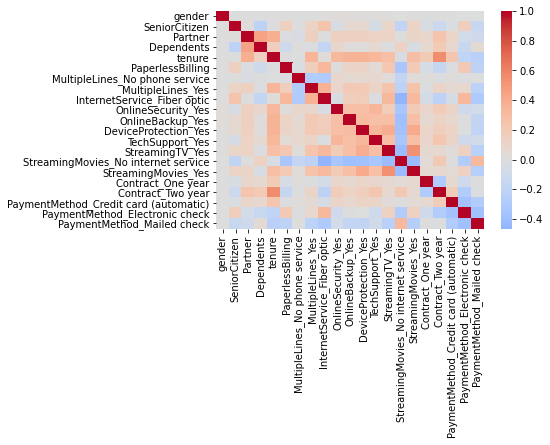

In [163]:
sns.heatmap( X_train.corr(), cmap='coolwarm', center=0, xticklabels=True ,yticklabels=True )
plt.show()

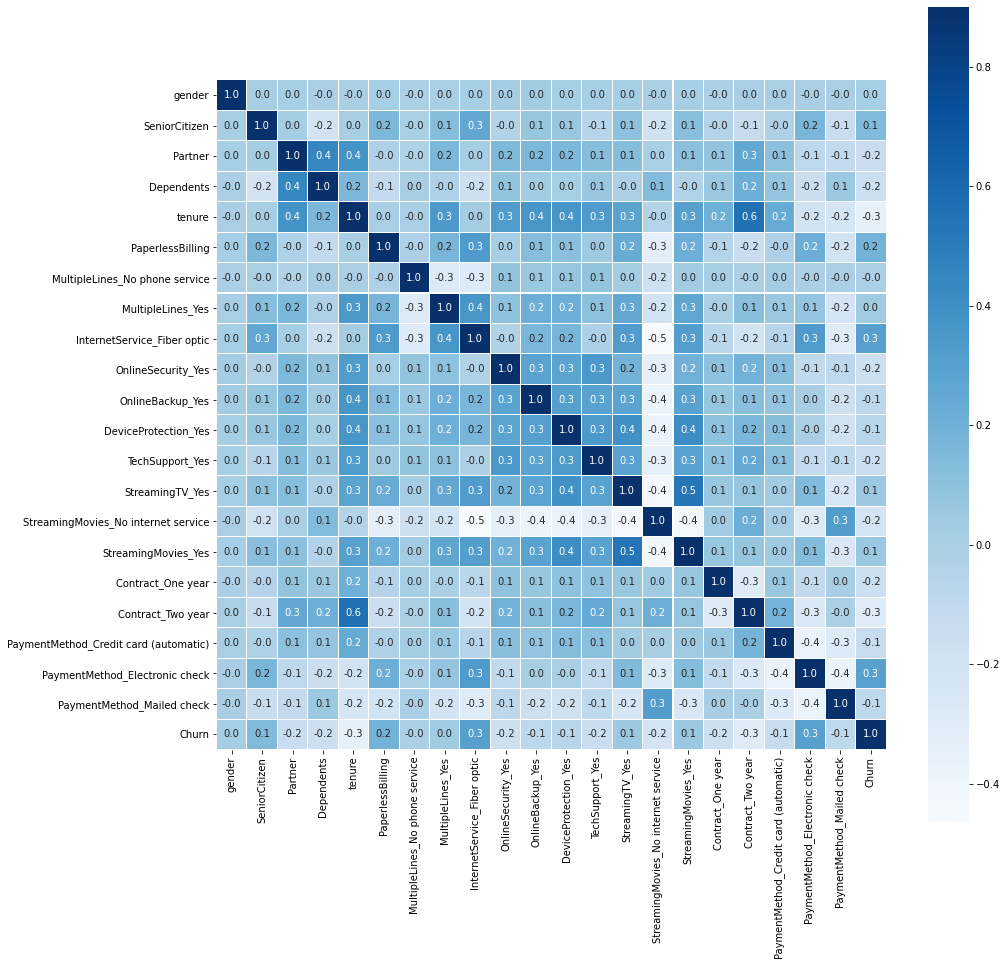

In [164]:
plt.subplots(figsize=(15,15))
sns.heatmap(X_train.assign(**y_train).corr(), vmax=0.9, square=True, cmap="Blues", annot=True, fmt='.1f', linewidth='.1')
plt.show()

In [165]:
correlations = X_train.corr()

In [166]:
correlations = correlations.unstack().reset_index()

In [167]:
# This step make sure that the 'gender and seniorcitizen' taken to account but not 'seniorcitizen and gender'
correlations = correlations[ correlations['level_0'] < correlations['level_1'] ]

In [168]:
correlations

,level_0,level_1,0
4,gender,tenure,-0.001318
21,SeniorCitizen,gender,0.005691
25,SeniorCitizen,tenure,0.006169
33,SeniorCitizen,TechSupport_Yes,-0.057097
34,SeniorCitizen,StreamingTV_Yes,0.102617
...,...,...,...
424,PaymentMethod_Mailed check,tenure,-0.233260
432,PaymentMethod_Mailed check,TechSupport_Yes,-0.087459
433,PaymentMethod_Mailed check,StreamingTV_Yes,-0.246234
434,PaymentMethod_Mailed check,StreamingMovies_No internet service,0.324005


In [169]:
correlations.sort_values( by=0, ascending=False ).head(100)

,level_0,level_1,0
361,Contract_Two year,tenure,0.556371
328,StreamingMovies_Yes,StreamingTV_Yes,0.537105
65,Dependents,Partner,0.447629
246,DeviceProtection_Yes,StreamingMovies_Yes,0.412912
244,DeviceProtection_Yes,StreamingTV_Yes,0.393215
46,Partner,tenure,0.382443
175,InternetService_Fiber optic,MultipleLines_Yes,0.366256
214,OnlineBackup_Yes,tenure,0.361964
235,DeviceProtection_Yes,tenure,0.361612
201,OnlineSecurity_Yes,TechSupport_Yes,0.346586


In [170]:
sorted( correlations.values, key=lambda x: abs(x[2]), reverse=True )

[array(['Contract_Two year', 'tenure', 0.5563711949994086], dtype=object),
 array(['StreamingMovies_Yes', 'StreamingTV_Yes', 0.5371052575167651],
       dtype=object),
 array(['InternetService_Fiber optic',
        'StreamingMovies_No internet service', -0.4651236531711398],
       dtype=object),
 array(['Dependents', 'Partner', 0.44762872068299736], dtype=object),
 array(['StreamingMovies_No internet service', 'StreamingMovies_Yes',
        -0.4205253086916726], dtype=object),
 array(['StreamingMovies_No internet service', 'StreamingTV_Yes',
        -0.4183512506710996], dtype=object),
 array(['DeviceProtection_Yes', 'StreamingMovies_Yes', 0.41291157752553564],
       dtype=object),
 array(['DeviceProtection_Yes', 'StreamingTV_Yes', 0.39321485669356276],
       dtype=object),
 array(['PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
        -0.3872308684745907], dtype=object),
 array(['OnlineBackup_Yes', 'StreamingMovies_No internet service',
        -0.38593416826668286

## Look at feature correlations with churn

In [171]:
X_train.assign(**y_train).corr()[['Churn']].sort_values( by='Churn', ascending=False )

,Churn
Churn,1.000000
InternetService_Fiber optic,0.300112
PaymentMethod_Electronic check,0.294180
PaperlessBilling,0.188793
SeniorCitizen,0.146549
StreamingMovies_Yes,0.060152
StreamingTV_Yes,0.054414
MultipleLines_Yes,0.033019
gender,0.011997
MultipleLines_No phone service,-0.010122


## 03. Basic Modeling

## Set up the modeling pipeline

1. Train the model.
2. Evaluate how good the model is. (Look at the results)
3. Pickle the model to the models directory
4. Save the model reslults to a CSV to track how each of our models performs.

## Split off training and validation sets

In [172]:
X, X_validation, y , y_validation = train_test_split( X_train, y_train, test_size=0.25, random_state=42 )

In [173]:
X.shape, y.shape, X_validation.shape, y_validation.shape

((3961, 21), (3961, 1), (1321, 21), (1321, 1))

## Set up our model

In [174]:
model = LogisticRegression()

In [175]:
model.fit(X, y)

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression()

In [176]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [177]:
# Model accuracy - manual
np.mean( model.predict(X_validation) == y_validation.values[:, 0].astype(int) )

0.7993943981831946

In [178]:
# Model accuracy - scikit-learn
model.score( X_validation, y_validation )

0.7993943981831946

## Pickle our model

## Save model results to CSV file

## Test our model-storing function

In [179]:
store_model_and_results( model, X_train, y_train )

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

fitting model before pickling
saving pickled model to 2153834124007332864.pkl
model results file does not exits - Creating new model results CSV file and         writing results


/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [180]:
print_model_results(model, X_train, y_train)

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

accuracy: 0.80


/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

precision: 0.65


/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

recall: 0.53


/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

f1: 0.58
roc_auc: 0.84


/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

## Test new model-storing function with additional metrics

In [181]:
model = LogisticRegression(max_iter=1000)
store_model_and_results( model, X_train, y_train )

fitting model before pickling
saving pickled model to 1549978681758692096.pkl
writing model results to existing results CSV file


/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [182]:
print_model_results(model, X_train, y_train)

accuracy: 0.80
precision: 0.65
recall: 0.53
f1: 0.58
roc_auc: 0.84


## 04. Interpreting Logistic Regression Model

## Load model results

In [183]:
model_results = load_model_results()

In [184]:
model_results

,model_filename,model_string,accuracy,precision,recall,f1,roc_auc
0,2153834124007332864.pkl,LogisticRegression(),0.800262,0.648375,0.529496,0.582486,0.838888
1,1549978681758692096.pkl,LogisticRegression(max_iter=1000),0.799884,0.647493,0.528777,0.581676,0.838857


In [186]:
model = load_pickled_model('1549978681758692096.pkl')

In [187]:
model

LogisticRegression(max_iter=1000)

In [188]:
# load last 
with open(os.path.join(MODELS_DIRECTORY, '1549978681758692096.pkl'), 'rb') as f:
    model = pickle.load(f)

In [189]:
model

LogisticRegression(max_iter=1000)

In [190]:
# looks at model weights
model.coef_

array([[ 0.05021439,  0.14906549,  0.01506256, -0.17128009, -0.03207858,
         0.30467565,  0.48178811,  0.28636316,  0.86504288, -0.41482827,
        -0.14322766,  0.01404467, -0.2994808 ,  0.18920143, -0.80975291,
         0.31616398, -0.64353624, -1.45383587, -0.11869769,  0.31477687,
        -0.02140992]])

In [191]:
sorted( list(zip( X_train.columns, model.coef_[0] )), key=lambda x: abs(x[1]), reverse=True )

[('Contract_Two year', -1.4538358728342435),
 ('InternetService_Fiber optic', 0.8650428813923032),
 ('StreamingMovies_No internet service', -0.8097529107578705),
 ('Contract_One year', -0.6435362442665401),
 ('MultipleLines_No phone service', 0.48178810972802166),
 ('OnlineSecurity_Yes', -0.41482827289934643),
 ('StreamingMovies_Yes', 0.3161639751211253),
 ('PaymentMethod_Electronic check', 0.3147768690834149),
 ('PaperlessBilling', 0.30467565469863767),
 ('TechSupport_Yes', -0.29948079864528165),
 ('MultipleLines_Yes', 0.2863631561145669),
 ('StreamingTV_Yes', 0.18920142902018547),
 ('Dependents', -0.17128009056772492),
 ('SeniorCitizen', 0.1490654934958141),
 ('OnlineBackup_Yes', -0.14322765737491377),
 ('PaymentMethod_Credit card (automatic)', -0.11869769282616147),
 ('gender', 0.05021439302332313),
 ('tenure', -0.03207858334832214),
 ('PaymentMethod_Mailed check', -0.0214099198851657),
 ('Partner', 0.015062562042350357),
 ('DeviceProtection_Yes', 0.014044670281203769)]

## Caveats

1. Our features have different scales. In particular, tenure has a scale of -1-70, while most other columns have a 
scale of 0-1. Also, TotalCharges and MonthlyCharges have larger scales. we cannot currently say which features are
most important because we didn't sacle (or normalize) our features.
2. Many of our features are highly or perfectly correlated. This also means we cannot tell which features are most
important, because of the effects of multicollinearty

## 05. Training Different Models

In [192]:
models_to_train = [
    DecisionTreeClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier
]

In [193]:
for model_class in models_to_train:
    print(model_class.__name__)
    model = model_class()
    store_model_and_results( model, X_train, y_train )
    print_model_results( model, X_train, y_train )

DecisionTreeClassifier
fitting model before pickling
saving pickled model to 1289054018694105856.pkl
writing model results to existing results CSV file
accuracy: 0.73
precision: 0.48
recall: 0.49
f1: 0.47
roc_auc: 0.66
AdaBoostClassifier
fitting model before pickling
saving pickled model to 1146463669484237056.pkl
writing model results to existing results CSV file


/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


accuracy: 0.80
precision: 0.65
recall: 0.52
f1: 0.58
roc_auc: 0.84
GradientBoostingClassifier
fitting model before pickling


/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


saving pickled model to 2115072070668834304.pkl
writing model results to existing results CSV file
accuracy: 0.81
precision: 0.67
recall: 0.52
f1: 0.58
roc_auc: 0.84
RandomForestClassifier
fitting model before pickling


../src/models/train_model.py:50: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit( X_train, y_train )


saving pickled model to 1950965584397562624.pkl
writing model results to existing results CSV file
accuracy: 0.78
precision: 0.61
recall: 0.46
f1: 0.52
roc_auc: 0.81


## Load Model Results

In [194]:
model_results = load_model_results()

In [195]:
sorted_model_results = model_results.sort_values( by='roc_auc', ascending=False )
sorted_model_results

,model_filename,model_string,accuracy,precision,recall,f1,roc_auc
3,1146463669484237056.pkl,AdaBoostClassifier(),0.800070,0.650880,0.520863,0.578054,0.844914
4,2115072070668834304.pkl,GradientBoostingClassifier(),0.805940,0.671295,0.515827,0.582726,0.844507
0,2153834124007332864.pkl,LogisticRegression(),0.800262,0.648375,0.529496,0.582486,0.838888
1,1549978681758692096.pkl,LogisticRegression(max_iter=1000),0.799884,0.647493,0.528777,0.581676,0.838857
5,1950965584397562624.pkl,RandomForestClassifier(),0.779815,0.592948,0.449640,0.523403,0.810109
2,1289054018694105856.pkl,DecisionTreeClassifier(),0.722642,0.470494,0.474820,0.480827,0.660533


/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

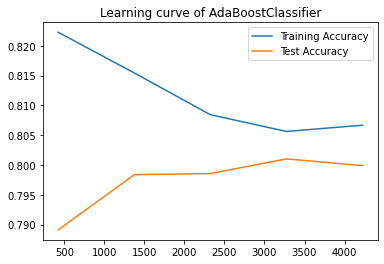

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

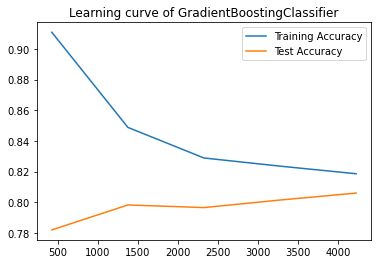

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array w

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP:

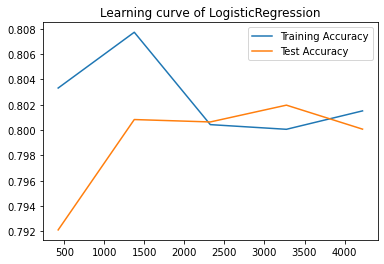

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

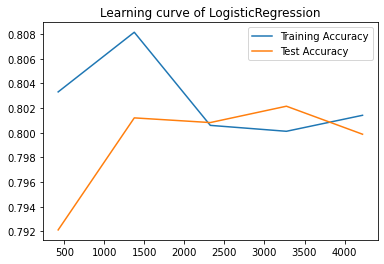

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

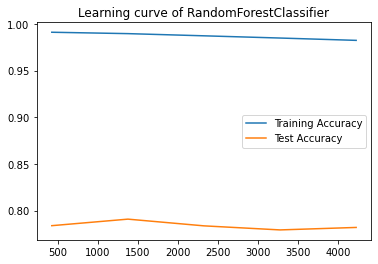

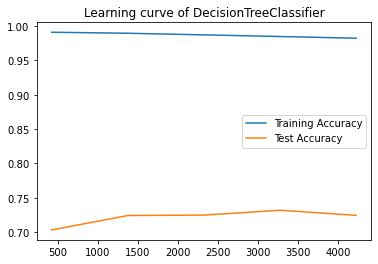

In [196]:
for pkl_file in sorted_model_results['model_filename']:
    model = load_pickled_model(pkl_file)
    plot_learning_curve(model, X_train, y_train, zoom_out=False)

## Visualize model performance

1. In this section, we are going to use **ROC curves** to visualize the overall classification performance of out models.

### ROC curves

### Plot ROC curves for all of our models

In [197]:
X_train_subset, X_validation, y_train_subset, y_validation = train_test_split( X_train, y_train, 
                                                                              test_size=0.25, random_state=42)

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

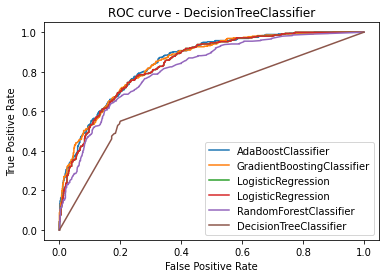

In [198]:
for pkl_file in sorted_model_results['model_filename']:
    model = load_pickled_model(pkl_file)
    model.fit(X_train_subset, y_train_subset)
    y_score = model.predict_proba(X_validation)
    y_score = y_score[:, 1]
    fpr, tpr, thresholds = roc_curve( y_validation, y_score )
    plt.plot( fpr, tpr, label=f"{type(model).__name__}" )
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    _ = plt.title( f"ROC curve - {type(model).__name__}" )
    #plt.show()
_ = plt.legend()

## 07. Hyperparameter Tunning

### Experiment with AdaBoost Hyperparameters
#### Experiment with number of estimators

In [28]:
# model = AdaBoostClassifier(n_estimators=100)
# print_model_results(model, X_train, y_train)

accuracy: 0.80
precision: 0.65
recall: 0.52
f1: 0.58
roc_auc: 0.84


In [23]:
# model.fit(X_train, y_train)

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


AdaBoostClassifier(n_estimators=1)

In [26]:
# Counter(model.predict(X_train))

Counter({0: 5282})

#### Experiment with learning rates

In [29]:
# model = AdaBoostClassifier(learning_rate=0.1)
# print_model_results(model, X_train, y_train)

accuracy: 0.79
precision: 0.71
recall: 0.32
f1: 0.44
roc_auc: 0.84


In [30]:
# model = AdaBoostClassifier(learning_rate=10)
# print_model_results(model, X_train, y_train)

accuracy: 0.26
precision: 0.26
recall: 1.00
f1: 0.42
roc_auc: 0.33


In [31]:
# model = AdaBoostClassifier(learning_rate=0.3)
# print_model_results(model, X_train, y_train)

accuracy: 0.80
precision: 0.67
recall: 0.48
f1: 0.56
roc_auc: 0.84


In [32]:
# model = AdaBoostClassifier(learning_rate=3)
# print_model_results(model, X_train, y_train)

accuracy: 0.26
precision: 0.26
recall: 1.00
f1: 0.42
roc_auc: 0.60


In [35]:
# model = AdaBoostClassifier(learning_rate=0.6)
# print_model_results(model, X_train, y_train)
# store_model_and_results(model, X_train, y_train)

accuracy: 0.80
precision: 0.66
recall: 0.50
f1: 0.57
roc_auc: 0.85
fitting model before pickling
saving pickled model to 2165931554359270144.pkl
writing model results to existing results CSV file


/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [34]:
# model = AdaBoostClassifier(learning_rate=1.5)
# print_model_results(model, X_train, y_train)

accuracy: 0.80
precision: 0.66
recall: 0.53
f1: 0.59
roc_auc: 0.84


### Hyperparameter Tuning - GridSearchCV

In [69]:
# rfc = RandomForestClassifier()

In [70]:
# rfc.fit(X_train, y_train)

<ipython-input-70-823e2bba21ee>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


RandomForestClassifier()

In [71]:
# print_model_results( rfc, X_train, y_train )

accuracy: 0.78
precision: 0.60
recall: 0.46
f1: 0.52
roc_auc: 0.81


In [72]:
# rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [73]:
# # RandomForestClassifier

# from sklearn.model_selection import GridSearchCV
# import numpy as np

# max_features_range = np.arange(1,X_train.shape[1],2)
# n_estimators_range = np.arange(10,210,10)
# param_grid = dict(max_features=max_features_range, n_estimators=n_estimators_range)

# rf = RandomForestClassifier()

# grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [74]:
# grid.fit(X_train, y_train)

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/mohankumar/anaconda3/envs/churn-m

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])})

In [75]:
# print("The best parameters are %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))

The best parameters are {'max_features': 11, 'n_estimators': 190} with a score of 0.78


In [6]:
# print_model_results( RandomForestClassifier(max_features=11, n_estimators=190), X_train, y_train )

accuracy: 0.78
precision: 0.60
recall: 0.46
f1: 0.53
roc_auc: 0.81


In [7]:
# print_model_results( RandomForestClassifier(), X_train, y_train )

accuracy: 0.78
precision: 0.60
recall: 0.45
f1: 0.52
roc_auc: 0.81


In [9]:
# #AdaBoostClassifier(learning_rate=0.6)
# #AdaBoostClassifier(n_estimators=100)
# # AdaBoostClassifier

# from sklearn.model_selection import GridSearchCV
# import numpy as np

# learning_rate_range = np.arange(0.1,1.1,0.1)
# n_estimators_range = np.arange(10,500,10)
# param_grid = dict(learning_rate=learning_rate_range, n_estimators=n_estimators_range)

# abc = AdaBoostClassifier()

# grid = GridSearchCV(estimator=abc, param_grid=param_grid, cv=5)

In [10]:
grid.fit(X_train, y_train)

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was pass

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490])})

In [11]:
# print("The best parameters are %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))

The best parameters are {'learning_rate': 0.1, 'n_estimators': 270} with a score of 0.80


In [13]:
# print_model_results( AdaBoostClassifier(learning_rate=0.1, n_estimators=270), X_train, y_train )

accuracy: 0.80
precision: 0.67
recall: 0.50
f1: 0.57
roc_auc: 0.85


In [14]:
# print_model_results( AdaBoostClassifier(), X_train, y_train )

accuracy: 0.80
precision: 0.65
recall: 0.52
f1: 0.58
roc_auc: 0.84


In [199]:
# Storing Hyperparameter tuned Adaboostclassifier model
model = AdaBoostClassifier(learning_rate=0.1, n_estimators=270)
print_model_results(model, X_train, y_train)
store_model_and_results(model, X_train, y_train)

accuracy: 0.80
precision: 0.67
recall: 0.50
f1: 0.57
roc_auc: 0.85
fitting model before pickling


/Users/mohankumar/anaconda3/envs/churn-model/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


saving pickled model to 2266049389248677376.pkl
writing model results to existing results CSV file


## 08. Interpreting our Final Model

In [200]:
model_results = load_model_results()

In [201]:
model_results.sort_values( by='roc_auc', ascending=False )

,model_filename,model_string,accuracy,precision,recall,f1,roc_auc
6,2266049389248677376.pkl,"AdaBoostClassifier(learning_rate=0.1, n_estima...",0.804048,0.673313,0.497122,0.571480,0.846463
3,1146463669484237056.pkl,AdaBoostClassifier(),0.800070,0.650880,0.520863,0.578054,0.844914
4,2115072070668834304.pkl,GradientBoostingClassifier(),0.805940,0.671295,0.515827,0.582726,0.844507
0,2153834124007332864.pkl,LogisticRegression(),0.800262,0.648375,0.529496,0.582486,0.838888
1,1549978681758692096.pkl,LogisticRegression(max_iter=1000),0.799884,0.647493,0.528777,0.581676,0.838857
5,1950965584397562624.pkl,RandomForestClassifier(),0.779815,0.592948,0.449640,0.523403,0.810109
2,1289054018694105856.pkl,DecisionTreeClassifier(),0.722642,0.470494,0.474820,0.480827,0.660533


In [205]:
model = load_pickled_model(load_model_results().sort_values( by='roc_auc', ascending=False ).iloc[0:1,]['model_filename'].values[0]) # Load AdaBoostClassifier Model

In [206]:
most_important_features = sorted(list(zip(X_train.columns ,np.round(model.feature_importances_,2))), 
                                 key=lambda x: abs(x[1]), reverse=True )
most_important_features

[('tenure', 0.39),
 ('MultipleLines_Yes', 0.07),
 ('MultipleLines_No phone service', 0.06),
 ('StreamingMovies_Yes', 0.06),
 ('Contract_One year', 0.05),
 ('PaperlessBilling', 0.04),
 ('InternetService_Fiber optic', 0.04),
 ('OnlineSecurity_Yes', 0.04),
 ('StreamingTV_Yes', 0.04),
 ('StreamingMovies_No internet service', 0.04),
 ('Contract_Two year', 0.04),
 ('TechSupport_Yes', 0.03),
 ('SeniorCitizen', 0.02),
 ('PaymentMethod_Electronic check', 0.02),
 ('PaymentMethod_Mailed check', 0.02),
 ('Dependents', 0.01),
 ('OnlineBackup_Yes', 0.01),
 ('gender', 0.0),
 ('Partner', 0.0),
 ('DeviceProtection_Yes', 0.0),
 ('PaymentMethod_Credit card (automatic)', 0.0)]

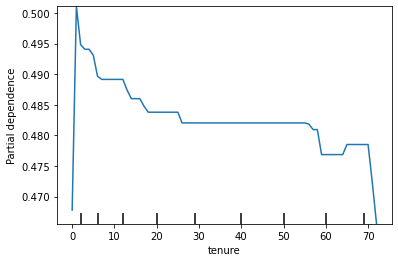

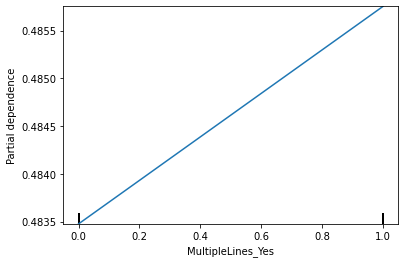

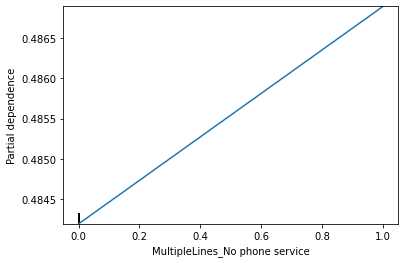

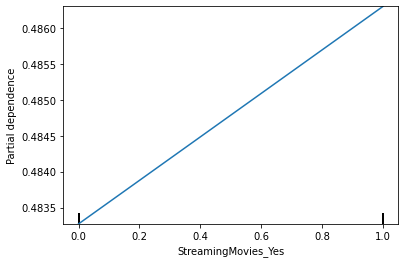

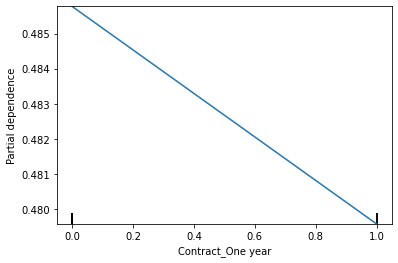

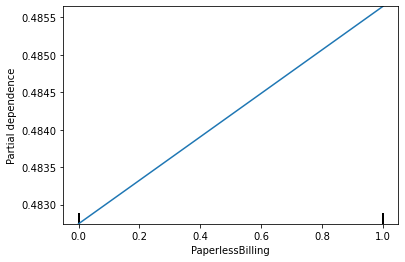

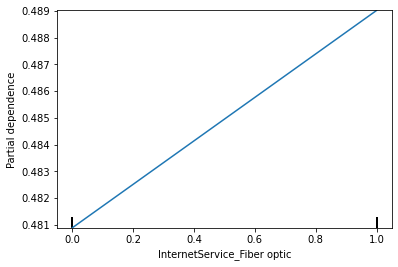

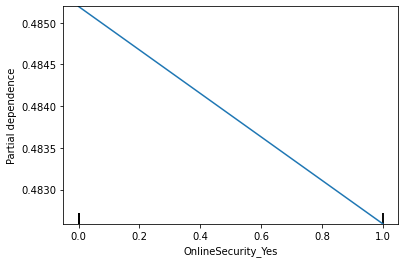

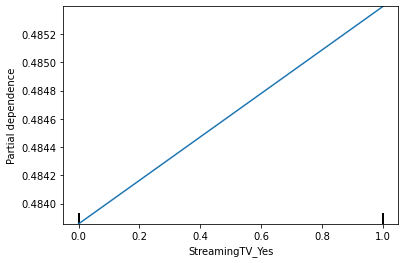

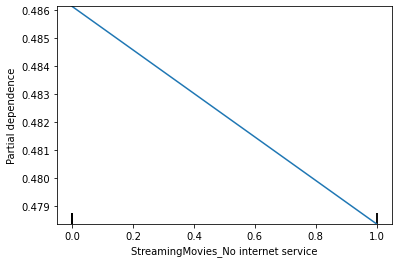

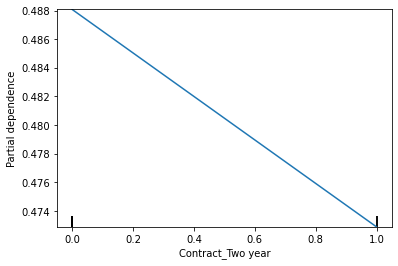

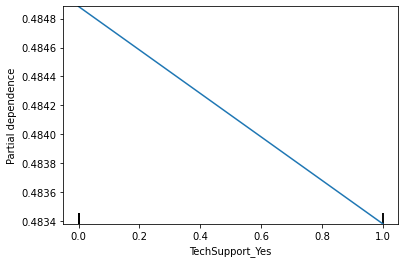

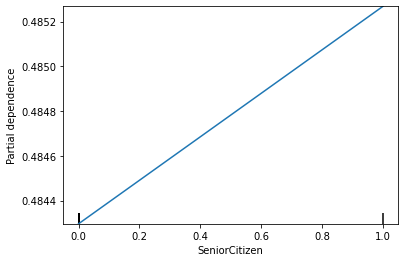

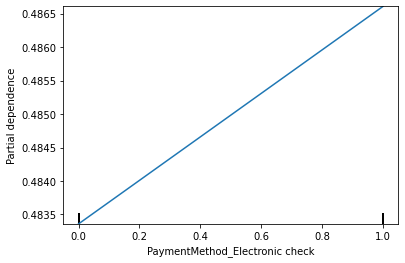

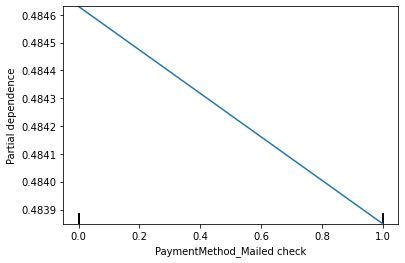

In [207]:
for col, val in most_important_features:
    if val > 0.01:
        plot_partial_dependence( estimator=model, X=X_train, features=[col] )

## 09. Evaluating our Model Using the Test Dataset

### Get predictions for our test data

In [208]:
y_score = predict(X_TEST_RAW_PATH, proba=True)

In [209]:
y_score

array([0.50871567, 0.47818525, 0.4564307 , ..., 0.47965036, 0.50548308,
       0.49255925])

### Evaluate our predictions

In [210]:
X_test, y_test = load_test_data()

In [211]:
y_test = y_test['Churn'].map({'Yes':1, 'No':0}).values

In [212]:
roc_auc_score( y_test, y_score ) # Test score of our model

0.8613531180078102